## Imports

In [44]:
import math
from sympy import Symbol
from sympy.solvers import solve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

## Key

In [1]:
percent_difficulty_drop = .2
number_of_blocks_till_eda = 6
number_of_minutes_till_eda = 12 * 60 # 12 hours * 60 min
Current_Hash_Power = 10606 * 1024 * 1024 * 1024 * 1024 * 1024 # hashes / sec
best_antminer = 4.73 * 1024 * 1024 * 1024 * 1024 # hashes / sec
best_antminer_price = 489.99 # dollars
cost_of_mining_equipment = ( 1.0 * Current_Hash_Power / best_antminer ) * best_antminer_price

## Helper Functions

In [106]:
def eda_will_kick_in(min_to_mine_one_block):
    return number_of_blocks_till_eda * min_to_mine_one_block > number_of_minutes_till_eda
def get_alpha(total_hashpower,my_hashpower):
    return 1.0 * my_hashpower / total_hashpower

In [132]:
class EDA_Calc:
    def __init__(self,percent_difficulty_drop,number_of_blocks_till_eda,number_of_minutes_till_eda):
        self.percent_difficulty_drop = percent_difficulty_drop
        self.number_of_blocks_till_eda = number_of_blocks_till_eda
        self.number_of_minutes_till_eda = number_of_minutes_till_eda
        self.average_minute_for_block = 10 # BTC has 10 min blocks
        self.calc_equation()
    
    def calc_equation(self):
        """
           b * x * ((1-p)**n) < m
           finds the smallest integer n that will solve this equation
        """
        x = Symbol('x') # min to mine one block
        n = Symbol('n') # number of edas that will happen
        m = Symbol('m') # min till eda could kick in
        b = Symbol('b') # number of blocks we look back on
        p = Symbol('p') # percent change
        equation = b * x * ((1-p)**n) - m # < 0
        equation = equation.subs(m,self.number_of_minutes_till_eda)
        equation = equation.subs(b,self.number_of_blocks_till_eda)
        equation = equation.subs(p,self.percent_difficulty_drop)
        self.equation = equation
    
    def how_many_edas_will_kick_in(self,var,solve_alpha=False):
        """
            b * x * ((1-p)**n) < m
            
            > (1-p)^n < m / (b*x)
            > n * log(1-p) < log(m/(b*x))
            > n < log(m/(b*x))/log(1-p)
            
            if solve_alpha is false, then var = x, else alpha
        
        """
        m = self.number_of_minutes_till_eda
        b = self.number_of_blocks_till_eda
        p = self.percent_difficulty_drop
        
        if solve_alpha:
            if var == 0:
                return np.inf
            x = self.average_minute_for_block / var
        else:
            if var == 0:
                return 0
            x = var
        top = math.log(1.0 * m/(b*x))
        bottom = math.log(1-p)
        return max(math.ceil( top / bottom ),0)
calc = EDA_Calc(percent_difficulty_drop,number_of_blocks_till_eda,number_of_minutes_till_eda)

## Plots

### # of EDAS that will kick in - Minutes to mine one block

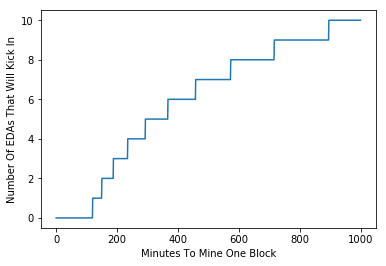

In [135]:
X = np.arange(0.0001,1000)
y = map(lambda e: calc.how_many_edas_will_kick_in(e),X)
plt.plot(X,y)
plt.xlabel('Minutes To Mine One Block')
plt.ylabel('Number Of EDAs That Will Kick In')

### # of EDAS that will kick in - alpha

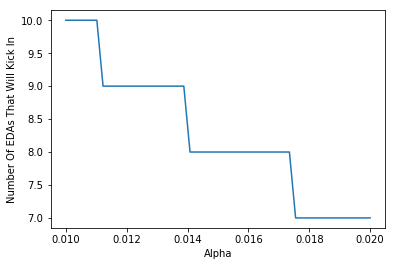

In [140]:
alpha = np.linspace(0.01,.02)
y = map(lambda e: calc.how_many_edas_will_kick_in(e,solve_alpha=True),alpha)
plt.plot(alpha,y)
plt.xlabel('Alpha')
plt.ylabel('Number Of EDAs That Will Kick In')

### Cost to get alpha of the current hashpower (in USD)

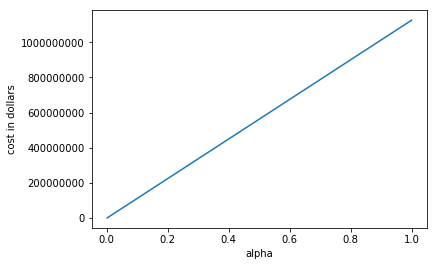

In [160]:
alpha = np.linspace(.001,1)
cost = map(lambda a: cost_of_mining_equipment * a, alpha)
plt.plot(alpha,cost)
plt.xlabel('alpha')
plt.ylabel('cost in dollars')
ax = plt.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(7,10))